In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

# 1. Data Importing & Wrangling

## 1.1 Import data and drop duplicates

In [3]:
# import data and drop duplicates
def import_data(file_name):
    df = pd.read_csv(f'Data/{file_name}', low_memory=False)
    
    print(f"The original file '{file_name}' has {len(df)} records.")
    df_dropped = df.drop_duplicates()
    print(f"{len(df)-len(df_dropped)} duplicates are detected and dropped, remaining {len(df_dropped)} records.\n")
    
    return df_dropped

In [4]:
airport = import_data('Airport_Codes.csv')
flights = import_data('Flights.csv')
tickets = import_data('Tickets.csv')

The original file 'Airport_Codes.csv' has 55369 records.
101 duplicates are detected and dropped, remaining 55268 records.

The original file 'Flights.csv' has 1915886 records.
4545 duplicates are detected and dropped, remaining 1911341 records.

The original file 'Tickets.csv' has 1167285 records.
71898 duplicates are detected and dropped, remaining 1095387 records.



## 1.2 Filter out unnecessary columns and records

In [5]:
# deal with airport dataset
airport = airport[(airport['ISO_COUNTRY']=='US')&((airport['TYPE']=='medium_airport')|(airport['TYPE']=='large_airport'))]
airport[['Longitude', 'Latitude']] = airport['COORDINATES'].str.split(',', expand=True).astype(float)
airport = airport.drop(['ELEVATION_FT','CONTINENT','ISO_COUNTRY','MUNICIPALITY','COORDINATES'],axis=1)
display(airport.head())
airport.shape

,TYPE,NAME,IATA_CODE,Longitude,Latitude
6194,medium_airport,Aleknagik / New Airport,WKK,-158.62,59.28
25963,medium_airport,South Alabama Regional At Bill Benton Field Ai...,NaN,-86.39,31.31
26143,medium_airport,Lehigh Valley International Airport,ABE,-75.44,40.65
26144,medium_airport,Abilene Regional Airport,ABI,-99.68,32.41
26145,large_airport,Albuquerque International Sunport,ABQ,-106.61,35.04


(858, 5)

In [6]:
# deal with flights dataset
flights = flights[flights['CANCELLED']==0]
flights = flights.drop(['FL_DATE','OP_CARRIER','OP_CARRIER_FL_NUM','TAIL_NUM','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'],axis=1) # here we keep 'CANCELLED' since we will use it to count the number of flights later on
display(flights.head())
flights.shape

,ORIGIN,ORIGIN_CITY_NAME,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,RSW,"Fort Myers, FL",CLE,"Cleveland, OH",-8.00,-6.00,0.00,143.0,1025.0,0.97
1,RSW,"Fort Myers, FL",CMH,"Columbus, OH",1.00,5.00,0.00,135.0,930.0,0.55
2,RSW,"Fort Myers, FL",CMH,"Columbus, OH",0.00,4.00,0.00,132.0,930.0,0.91
3,RSW,"Fort Myers, FL",CMH,"Columbus, OH",11.00,14.00,0.00,136.0,930.0,0.67
4,RSW,"Fort Myers, FL",DAL,"Dallas, TX",0.00,-17.00,0.00,151.0,1005.0,0.62


(1859862, 10)

In [7]:
# deal with tickets dataset
tickets = tickets[tickets['ROUNDTRIP']==1]  
tickets = tickets.drop(['ITIN_ID','YEAR','QUARTER','ORIGIN_COUNTRY','ORIGIN_STATE_ABR','ORIGIN_STATE_NM','ROUNDTRIP','REPORTING_CARRIER','PASSENGERS'],axis=1)
display(tickets.head())
tickets.shape

,ORIGIN,ITIN_FARE,DESTINATION
0,ABI,736.0,DAB
1,ABI,570.0,COS
2,ABI,564.0,MCO
3,ABI,345.0,LGA
10,ABI,1647.0,JAX


(661036, 3)

# 2. Data Quality Check & Cleaning

In [8]:
airport.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 6194 to 50008
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TYPE       858 non-null    object 
 1   NAME       858 non-null    object 
 2   IATA_CODE  821 non-null    object 
 3   Longitude  858 non-null    float64
 4   Latitude   858 non-null    float64
dtypes: float64(2), object(3)
memory usage: 40.2+ KB


In [9]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859862 entries, 0 to 1911340
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ORIGIN            object 
 1   ORIGIN_CITY_NAME  object 
 2   DESTINATION       object 
 3   DEST_CITY_NAME    object 
 4   DEP_DELAY         float64
 5   ARR_DELAY         float64
 6   CANCELLED         float64
 7   AIR_TIME          object 
 8   DISTANCE          object 
 9   OCCUPANCY_RATE    float64
dtypes: float64(4), object(6)
memory usage: 156.1+ MB


In [10]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661036 entries, 0 to 1115067
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ORIGIN       661036 non-null  object
 1   ITIN_FARE    660585 non-null  object
 2   DESTINATION  661036 non-null  object
dtypes: object(3)
memory usage: 20.2+ MB


## 2.1 Detect numeric format exception

Notice that the format of some solumns should be float, but are displayed as object, like:
* **AIR_TIME**, **DISTANCE** in flights dataset
* **ITIN_FARE** in tickets dataset

In [11]:
# detect the number of value with format exception in column
def detect_special_alpha_columns(col):
    special_chars_pattern = r'[!@#$%^&*(),.?":{}|<>]'
    special = col.str.contains(special_chars_pattern, regex=True).sum()
    alpha = col.str.isalpha().sum()
    print(f'{col.name} has {special} values which contain special characters, and {alpha} values which contain alphabetical values.')

In [12]:
detect_special_alpha_columns(flights['AIR_TIME'])

AIR_TIME has 1855186 values which contain special characters, and 2 values which contain alphabetical values.


In [13]:
detect_special_alpha_columns(flights['DISTANCE'])

DISTANCE has 1859575 values which contain special characters, and 4 values which contain alphabetical values.


In [14]:
detect_special_alpha_columns(tickets['ITIN_FARE'])

ITIN_FARE has 660011 values which contain special characters, and 0 values which contain alphabetical values.


In [15]:
# extract numeric values from column and convert to float
def extract_numeric_value(col):
    return col.str.extract(r'(\d+)').astype(float)

In [16]:
# extract numeric values and convert to float
flights['AIR_TIME'] = extract_numeric_value(flights['AIR_TIME'])
flights['DISTANCE'] = extract_numeric_value(flights['DISTANCE'])
tickets['ITIN_FARE'] = extract_numeric_value(tickets['ITIN_FARE'])

Since each plane can accommodate up to 200 passengers, so replacing **OCCUPANCY_RATE** with **Passenger_Num** = OCCUPANCY_RATE*200

In [17]:
# convert OCCUPANCY_RATE
flights['Passenger_Num'] = flights['OCCUPANCY_RATE']*200
flights = flights.drop('OCCUPANCY_RATE', axis=1)

In [18]:
# show if converted successfully
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859862 entries, 0 to 1911340
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ORIGIN            object 
 1   ORIGIN_CITY_NAME  object 
 2   DESTINATION       object 
 3   DEST_CITY_NAME    object 
 4   DEP_DELAY         float64
 5   ARR_DELAY         float64
 6   CANCELLED         float64
 7   AIR_TIME          float64
 8   DISTANCE          float64
 9   Passenger_Num     float64
dtypes: float64(6), object(4)
memory usage: 156.1+ MB


In [19]:
# show if converted successfully
tickets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661036 entries, 0 to 1115067
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ORIGIN       661036 non-null  object 
 1   ITIN_FARE    660585 non-null  float64
 2   DESTINATION  661036 non-null  object 
dtypes: float64(1), object(2)
memory usage: 20.2+ MB


## 2.2 Deal with outliers

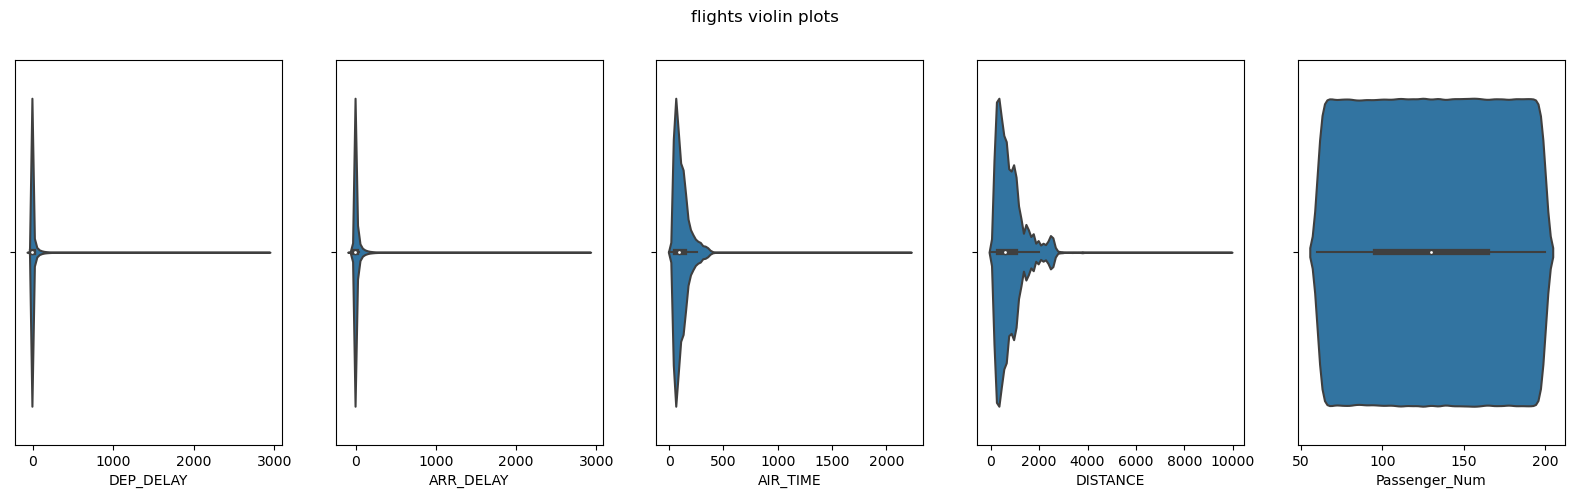

In [20]:
# create violin plots for numeric columns in flights dataset to show the data distribution
fig, ax = plt.subplots(1,5,figsize=(20,5))

sns.violinplot(x='DEP_DELAY',data=flights,ax=ax[0])
sns.violinplot(x='ARR_DELAY',data=flights,ax=ax[1])
sns.violinplot(x='AIR_TIME',data=flights,ax=ax[2])
sns.violinplot(x='DISTANCE',data=flights,ax=ax[3])
sns.violinplot(x='Passenger_Num',data=flights,ax=ax[4])

fig.suptitle('flights violin plots')
plt.show()

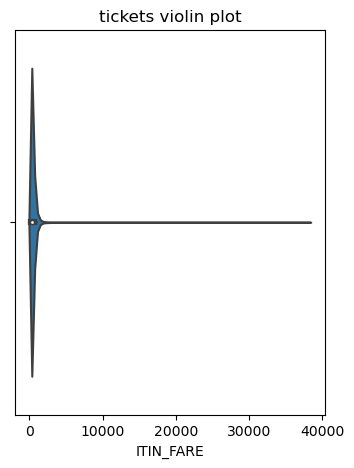

In [21]:
# create violin plots for numeric columns in tickets dataset
plt.figure(figsize=(4,5)) 
sns.violinplot(x='ITIN_FARE',data=tickets)
plt.title('tickets violin plot')
plt.show()

According to violin plots, we can notice that some values are too high which seems unreasonable, so these records should be considered as outliers:
* flights.DEP_DELAY > 300
* flights.ARR_DELAY > 400
* flights.AIR_TIME > 500
* flights.DISTANCE > 3000
* tickets.ITIN_FARE > 2500

Note: here I make the judgment by visual inspection, and we still need more information to confirm whether they are actual outliers.

In [22]:
# replace outliers with median value
def replace_outliers(df, col, upper_bound):
    median = df[col].median()
    df[col].loc[df[col]>upper_bound] = median

In [23]:
replace_outliers(flights, 'DEP_DELAY', 300)
replace_outliers(flights, 'ARR_DELAY', 400)
replace_outliers(flights, 'AIR_TIME', 500)
replace_outliers(flights, 'DISTANCE', 3000)
replace_outliers(tickets, 'ITIN_FARE', 2500)

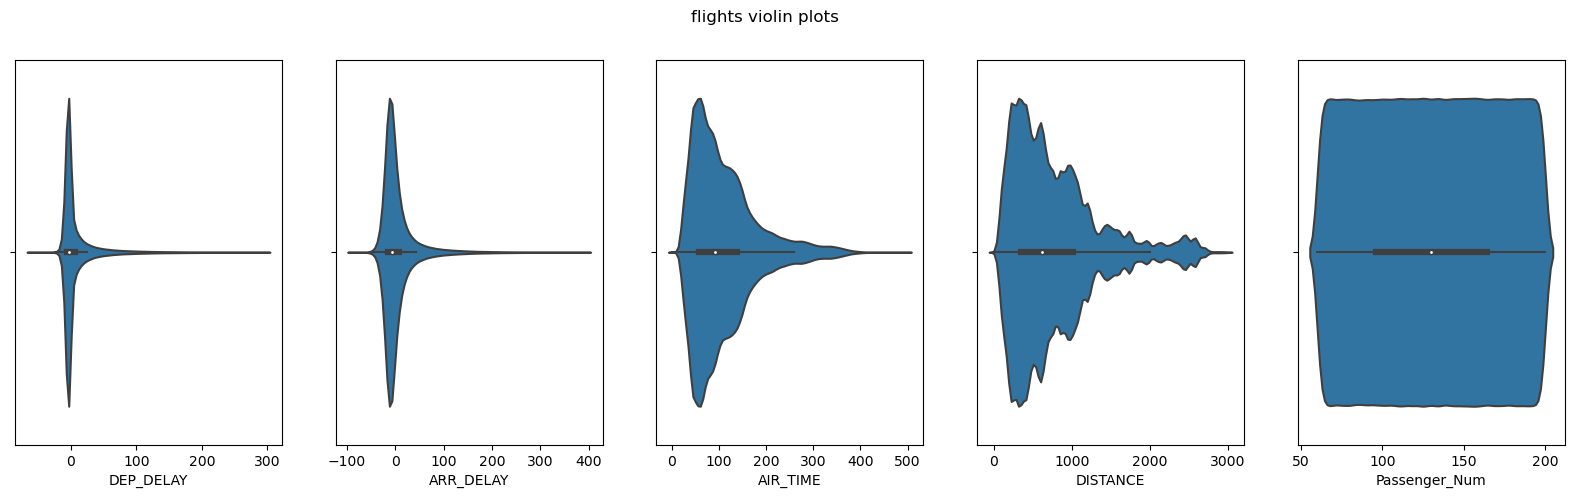

In [24]:
# display violin plots after removing outliers
fig, ax = plt.subplots(1,5,figsize=(20,5))

sns.violinplot(x='DEP_DELAY',data=flights,ax=ax[0])
sns.violinplot(x='ARR_DELAY',data=flights,ax=ax[1])
sns.violinplot(x='AIR_TIME',data=flights,ax=ax[2])
sns.violinplot(x='DISTANCE',data=flights,ax=ax[3])
sns.violinplot(x='Passenger_Num',data=flights,ax=ax[4])

fig.suptitle('flights violin plots')
plt.show()

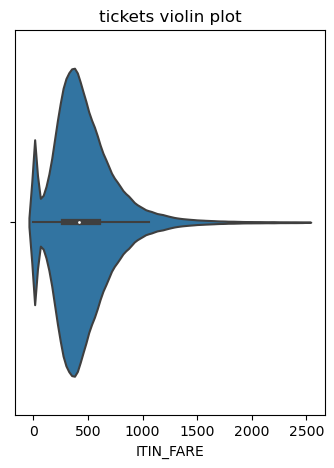

In [26]:
# display violin plot after removing outliers
plt.figure(figsize=(4,5)) 
sns.violinplot(x='ITIN_FARE',data=tickets)
plt.title('tickets violin plot')
plt.show()

## 2.3 Deal with missing value

In [27]:
# get the name of dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# display columns with missing values and their missing rates
def show_missing_columns(df):
    missing_rates = (df.isnull().mean() * 100)
    columns_with_missing = missing_rates[missing_rates > 0]
    
    if not columns_with_missing.empty:
        print(f"Columns with missing values in {get_df_name(df)} dataset and their missing rates:")
        for column, rate in columns_with_missing.items():
            print(f"{column}: {rate:.3f}%")
    else:
        print(f"No columns have missing values in {get_df_name(df)} dataset.")
        
    print('\n')

In [28]:
show_missing_columns(airport)
show_missing_columns(flights)
show_missing_columns(tickets)

Columns with missing values in airport dataset and their missing rates:
IATA_CODE: 4.312%


Columns with missing values in flights dataset and their missing rates:
ARR_DELAY: 0.235%
AIR_TIME: 0.248%
DISTANCE: 0.014%
Passenger_Num: 0.002%


Columns with missing values in tickets dataset and their missing rates:
ITIN_FARE: 0.068%




In [29]:
# for airport dataset, remove IATA_CODE missing records, since it's the basic necessity and we can do nothing about it
airport = airport.dropna(subset=['IATA_CODE'])

In [30]:
# for flights and tickets datasets, fill null values with median value as it's robust to outliers
flights = flights.fillna(flights.median())
tickets = tickets.fillna(tickets.median())

In [31]:
# check if we still have any null value
show_missing_columns(airport)
show_missing_columns(flights)
show_missing_columns(tickets)

No columns have missing values in airport dataset.


No columns have missing values in flights dataset.


No columns have missing values in tickets dataset.




## 2.4 Deal with negative values

Since we need to aggregate numeric values later on in order to merge dataframe efficiently, we would check if there's any negative values, and whether they would impact the following calculation.

In [32]:
flights.describe()

,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,Passenger_Num
count,1859862.00,1859862.00,1859862.00,1859862.00,1859862.00,1859862.00
mean,8.62,4.12,0.00,109.08,766.92,130.04
std,33.69,39.62,0.00,69.48,567.20,40.40
min,-63.00,-94.00,0.00,1.00,2.00,60.00
25%,-6.00,-15.00,0.00,59.00,344.00,96.00
50%,-2.00,-6.00,0.00,91.00,612.00,130.00
75%,6.00,8.00,0.00,139.00,1011.00,164.00
max,300.00,400.00,0.00,500.00,2994.00,200.00


In [33]:
tickets.describe()

,ITIN_FARE
count,661036.00
mean,464.44
std,299.46
min,0.00
25%,279.00
50%,415.00
75%,592.00
max,2500.00


In [34]:
# replace negative values with a setting number
def replace_negative(df,col,num):
    df[col].loc[df[col]<0] = num

According to the brand image, we would focus on punctuality instead of delay. So the negative values in DEP_DELAY or ARR_DELAY columns, which means early departures or arrivals, would be replaced with 0, since negative values would affect the following aggregation results.

In [35]:
# replace negative values with 0
replace_negative(flights,'DEP_DELAY',0)
replace_negative(flights,'ARR_DELAY',0)

In [36]:
# check if replaced successfully
flights.describe()

,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,Passenger_Num
count,1859862.00,1859862.00,1859862.00,1859862.00,1859862.00,1859862.00
mean,11.99,12.98,0.00,109.08,766.92,130.04
std,32.25,35.25,0.00,69.48,567.20,40.40
min,0.00,0.00,0.00,1.00,2.00,60.00
25%,0.00,0.00,0.00,59.00,344.00,96.00
50%,0.00,0.00,0.00,91.00,612.00,130.00
75%,6.00,8.00,0.00,139.00,1011.00,164.00
max,300.00,400.00,0.00,500.00,2994.00,200.00


**Data Quality Insights:**
1. Some numeric columns contain special characters or alphabetical values, such as *flights.AIR_TIME*, *flights.DISTANCE*, and *tickets.ITIN_FARE* indicating potential data type mismatches or encoding issues;
2. Some numeric columns have unusually high or low values compared to the rest, such as *flights.DEP_DELAY*, *flights.AIR_TIME*, and *tickets.ITIN_FARE*,  which might warrant further investigation to ensure data accuracy;
3. A certain percentage of records have missing values in critical columns such as *airport.IATA_CODE*. This could impact downstream analyses or reporting;
4. Several records appear to be duplicated in all three datasets, indicating the possibility of redundant data entry or integration issues.

# 3. Data Munging

Since the general task is to find routes, instead of simply merging three dataframes, we would group the tickets and flights dataframe based on origin and destination at first.

In [37]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859862 entries, 0 to 1911340
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   ORIGIN            object 
 1   ORIGIN_CITY_NAME  object 
 2   DESTINATION       object 
 3   DEST_CITY_NAME    object 
 4   DEP_DELAY         float64
 5   ARR_DELAY         float64
 6   CANCELLED         float64
 7   AIR_TIME          float64
 8   DISTANCE          float64
 9   Passenger_Num     float64
dtypes: float64(6), object(4)
memory usage: 156.1+ MB


In [38]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661036 entries, 0 to 1115067
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ORIGIN       661036 non-null  object 
 1   ITIN_FARE    661036 non-null  float64
 2   DESTINATION  661036 non-null  object 
dtypes: float64(1), object(2)
memory usage: 20.2+ MB


In [40]:
# aggregate flights based on ORIGIN and DESTINATION, and sum numeric value in each column
flights_agg = flights.groupby(['ORIGIN','DESTINATION']).aggregate({'ORIGIN_CITY_NAME':'first',
                                                                    'DEST_CITY_NAME': 'first',
                                                                    'DEP_DELAY': 'sum',
                                                                    'ARR_DELAY': 'sum',
                                                                    'CANCELLED': 'count',
                                                                    'AIR_TIME': 'sum',
                                                                    'DISTANCE': 'sum',
                                                                    'Passenger_Num':'sum'}).reset_index()

In [41]:
# rename column CANCELLED to Flight_Num
flights_agg.rename(columns={'CANCELLED':'Flight_Num'}, inplace=True)

In [42]:
# aggregate tickets based on ORIGIN and DESTINATION, and take median value of ITIN_FARE in aggregation, since observations have skewed distribution
tickets_agg = tickets.groupby(['ORIGIN','DESTINATION']).aggregate({'ITIN_FARE': 'median'}).reset_index()

In [43]:
# inner join flights_agg and tickets_agg
airline = flights_agg.merge(tickets_agg, on=['ORIGIN','DESTINATION'], how='inner')

In [44]:
airline.head()

,ORIGIN,DESTINATION,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,Flight_Num,AIR_TIME,DISTANCE,Passenger_Num,ITIN_FARE
0,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",1654.00,2981.00,217,23225.00,150164.00,27844.00,495.00
1,ABE,CLT,"Allentown/Bethlehem/Easton, PA","Charlotte, NC",2003.00,2854.00,251,24842.00,120731.00,33432.00,496.00
2,ABE,DTW,"Allentown/Bethlehem/Easton, PA","Detroit, MI",3700.00,4601.00,248,20691.00,105400.00,31698.00,525.00
3,ABE,FLL,"Allentown/Bethlehem/Easton, PA","Fort Lauderdale, FL",334.00,350.00,20,2913.00,20820.00,2320.00,193.00
4,ABE,ORD,"Allentown/Bethlehem/Easton, PA","Chicago, IL",3593.00,4371.00,159,17637.00,103986.00,21344.00,544.00


Since we are considering round trip here, which is the combination of JFK to ORD and ORD to JFK, the opposite order of the route, ORD to JFK and JFK to ORD, would be considered the same round trip. So I would sort the 'ORIGIN' and 'DESTINATION' values within each row to create a consistent identifier for the round trip route, regardless of the order of the airports.

In [45]:
# sort and concatenate airport codes
def sort_airports(df):
    return '-'.join(sorted([df['ORIGIN'], df['DESTINATION']]))

In [46]:
# add a new column 'Route', group by with 'Route' and aggregate other columns as needed
airline['Route'] = airline.apply(sort_airports, axis=1)

# Group by the new column and aggregate as needed
airline = airline.groupby('Route').agg({'ORIGIN': 'first',
                                        'DESTINATION': 'first',
                                        'ORIGIN_CITY_NAME': 'first',
                                        'DEST_CITY_NAME': 'first',
                                        'DEP_DELAY': 'sum',
                                        'ARR_DELAY': 'sum',
                                        'AIR_TIME': 'sum',
                                        'Flight_Num': 'sum',
                                        'DISTANCE': 'sum',
                                        'Passenger_Num': 'sum',
                                        'ITIN_FARE': 'median'}).reset_index()

In [47]:
# add prefix to a list of columns
def add_prefix(df, column_list, prefix):
    new_columns = [prefix + col if col in column_list else col for col in df.columns]
    df.columns = new_columns

In [48]:
# inner join airline with airport based on ORIGIN
airline = airline.merge(airport, left_on='ORIGIN', right_on='IATA_CODE')

# drop IATA_CODE and rename columns
airline.drop(columns=['IATA_CODE'], inplace=True)
add_prefix(airline, ['TYPE','NAME','Longitude','Latitude'], 'Origin_')

In [49]:
# inner join airline with airport based on DESTINATION
airline = airline.merge(airport, left_on='DESTINATION', right_on='IATA_CODE')

# drop IATA_CODE and rename columns
airline.drop(columns=['IATA_CODE'], inplace=True)
add_prefix(airline, ['TYPE','NAME','Longitude','Latitude'], 'Destination_')

In [50]:
# create data profile html file
profile = ProfileReport(airline, title='Airline Profiling Report', html={'style':{'full_width':True}})
profile.to_file("airline_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 4. Data Visualization and Recommendation

## Task 1: 10 busiest round trip routes
The 10 busiest round trip routes in terms of number of round trip flights in the quarter.

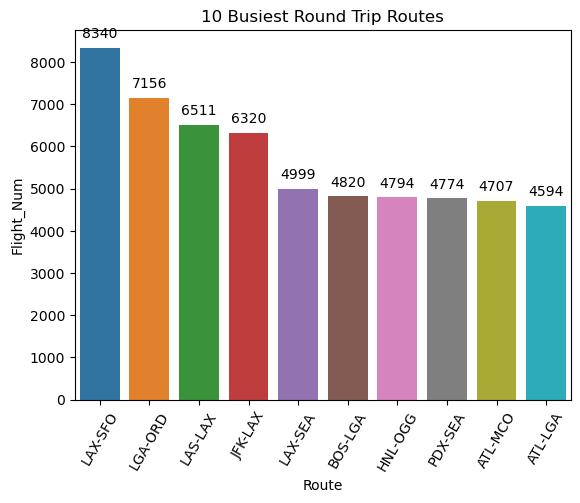

In [51]:
task_1 = airline.sort_values(by='Flight_Num',ascending=False)[:10]

ax = sns.barplot(x=task_1['Route'],y=task_1['Flight_Num'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
ax.set_title("10 Busiest Round Trip Routes")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [52]:
task_1[['Route','ORIGIN_CITY_NAME','DEST_CITY_NAME','Passenger_Num','Flight_Num']]

,Route,ORIGIN_CITY_NAME,DEST_CITY_NAME,Passenger_Num,Flight_Num
1064,LAX-SFO,"Los Angeles, CA","San Francisco, CA",1082554.00,8340
178,LGA-ORD,"New York, NY","Chicago, IL",929026.00,7156
579,LAS-LAX,"Las Vegas, NV","Los Angeles, CA",845678.00,6511
577,JFK-LAX,"New York, NY","Los Angeles, CA",821694.00,6320
994,LAX-SEA,"Los Angeles, CA","Seattle, WA",654284.00,4999
2395,BOS-LGA,"Boston, MA","New York, NY",627434.00,4820
2214,HNL-OGG,"Honolulu, HI","Kahului, HI",620950.00,4794
1012,PDX-SEA,"Portland, OR","Seattle, WA",620644.00,4774
608,ATL-MCO,"Atlanta, GA","Orlando, FL",611424.00,4707
2390,ATL-LGA,"Atlanta, GA","New York, NY",598240.00,4594


## Task 2: 10 most profitable round trip routes
The 10 most profitable round trip routes (without considering the upfront airplane cost) in the quarter. Along with the profit, show total revenue, total cost, summary values of other key components and total round trip flights in the quarter for the top 10 most profitable routes.

**Costs:**
- Fuel, Oil, Maintenance, Crew - $8 per mile total

- Depreciation, Insurance, Other - $1.18 per mile total

- Airport operational costs for the right to use the airports and related services are fixed at \\$5,000 for medium airports and \\$10,000 for large airports. There is one charge for each airport where a flight lands. Thus, a round trip flight has a total of two airport charges.

- Delays that are 15 minutes or less are free, however each additional minute of delay costs the airline $75 in added operational costs. This is charged separately for both arrival and departure delays.

- *Each airplane will cost $90 million (exclude in this task)

In [53]:
task_2 = airline.copy()

In [54]:
# calculate cost
task_2['Cost_Maintenance'] = task_2['DISTANCE']*(8+1.18)
task_2['Cost_Operation'] = (task_2['Flight_Num'] * np.where(task_2['Origin_TYPE'] == 'medium_airport', 5000, 10000)) + \
                            (task_2['Flight_Num'] * np.where(task_2['Destination_TYPE'] == 'medium_airport', 5000, 10000))
task_2['Cost_Delay'] = (task_2['DEP_DELAY']-15)*75 + (task_2['ARR_DELAY']-15)*75

task_2['Total_Cost'] = task_2['Cost_Maintenance']+task_2['Cost_Operation']+task_2['Cost_Delay']

**Revenue:**
- Each plane can accommodate up to 200 passengers and each flight has an associated occupancy rate provided in the Flights data set.

- Baggage fee is \\$35 for each checked bag per flight. We expect 50% of passengers to check an average of 1 bag per flight. The fee is charged separately for each leg of a round trip flight, thus 50% of passengers will be charged a total of \\$70 in baggage fees for a round trip flight.

In [55]:
# calculate revenue
task_2['Revenue_Fare'] = task_2['Passenger_Num'] * task_2['ITIN_FARE']
task_2['Revenue_Baggage'] = task_2['Passenger_Num']*0.5*70
task_2['Total_Revenue'] = task_2['Revenue_Fare'] + task_2['Revenue_Baggage']

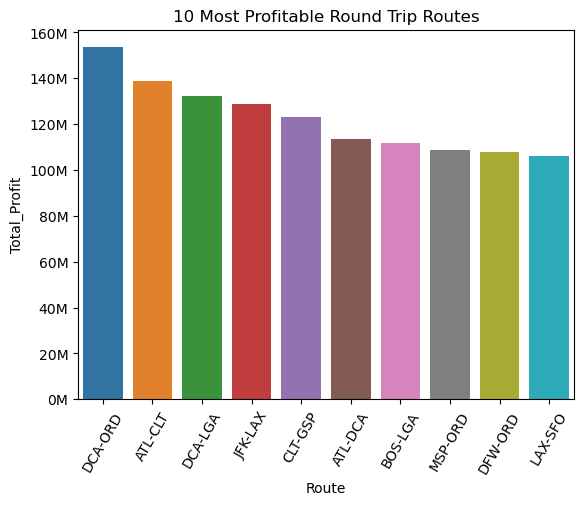

In [56]:
task_2['Total_Profit'] = task_2['Total_Revenue'] - task_2['Total_Cost']
task_2.rename(columns={'Flight_Num':'Total_Flight_Num','Passenger_Num':'Total_Passenger_Num'}, inplace=True)
task_2re = task_2.sort_values(by='Total_Profit', ascending=False)[:10]

ax = sns.barplot(x=task_2re['Route'],y=task_2re['Total_Profit'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
ax.set_title("10 Most Profitable Round Trip Routes")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.0f}M'))

plt.show()

In [57]:
task_2re[['Route','ORIGIN_CITY_NAME','DEST_CITY_NAME','Cost_Maintenance','Cost_Operation','Cost_Delay','Total_Cost','Revenue_Fare','Revenue_Baggage','Total_Revenue','Total_Flight_Num','Total_Profit']]

,Route,ORIGIN_CITY_NAME,DEST_CITY_NAME,Cost_Maintenance,Cost_Operation,Cost_Delay,Total_Cost,Revenue_Fare,Revenue_Baggage,Total_Revenue,Total_Flight_Num,Total_Profit
132,DCA-ORD,"Washington, DC","Chicago, IL",20759101.20,73900000,7970025.00,102629126.20,239407000.00,16758490.00,256165490.00,3695,153536363.80
11,ATL-CLT,"Atlanta, GA","Charlotte, NC",6381715.68,61520000,3498525.00,71400240.68,196400496.00,13971580.00,210372076.00,3076,138971835.32
2409,DCA-LGA,"Washington, DC","New York, NY",6598822.68,67180000,9065850.00,82844672.68,199702132.00,15344840.00,215046972.00,3359,132202299.32
577,JFK-LAX,"New York, NY","Los Angeles, CA",143593560.00,126400000,9762300.00,279755860.00,379622628.00,28759290.00,408381918.00,6320,128626058.00
1888,CLT-GSP,"Charlotte, NC","Greer, SC",1065109.50,30940000,2035650.00,34040759.50,150081815.00,7034300.00,157116115.00,1547,123075355.50
1808,ATL-DCA,"Atlanta, GA","Washington, DC",17514852.48,69760000,4222425.00,91497277.48,188981877.00,15880830.00,204862707.00,3488,113365429.52
2395,BOS-LGA,"Boston, MA","New York, NY",8141558.40,96400000,15454950.00,119996508.40,210033531.50,21960190.00,231993721.50,4820,111997213.10
189,MSP-ORD,"Minneapolis, MN","Chicago, IL",10547452.80,68800000,8659050.00,88006502.80,181011852.00,15858360.00,196870212.00,3440,108863709.20
135,DFW-ORD,"Dallas/Fort Worth, TX","Chicago, IL",24074880.48,65480000,8507175.00,98062055.48,190701738.00,15092280.00,205794018.00,3274,107731962.52
1064,LAX-SFO,"Los Angeles, CA","San Francisco, CA",25801124.40,166800000,26654175.00,219255299.40,287418087.00,37889390.00,325307477.00,8340,106052177.60


## Task 3: 5 recommended round trip routes
The 5 round trip routes that you recommend to invest in based on any factors that you choose.

* Specific routes exhibited lower operational frequencies during this quarter, and a subset of flights recorded notably limited passenger counts. Given the potential volatility and unreliability associated with making decisions based on such sparse data points, a cautious approach is warranted. To address this, we have taken the initiative to filter out routes with flight numbers fewer than 100 and passenger counts below 10,000. 

* Additionally, it's imperative to consider the potential for profitability. To address this, we exclude routes that do not yield a profit.

In [58]:
task_3 = task_2.copy()
task_3re = task_3[(task_3['Total_Flight_Num']>=100) & (task_3['Total_Passenger_Num']>=10000) & (task_3['Total_Profit']>0)]
print(f'{task_3.shape[0]-task_3re.shape[0]} routes are filtered out, and the remaining number of routes is: {task_3re.shape[0]}')

470 routes are filtered out, and the remaining number of routes is: 2323


* In order to get breakeven as soon as possible, we use Profit_per_Trip as a key factor
* While profitability is a significant consideration, the airline industry's volatility is influenced by various factors such as fuel prices, weather conditions, and more. Given this unpredictability, selecting flight routes with higher profit margins becomes crucial. This strategy provides a safety net to mitigate potential disruptions, allowing for better resilience in case unforeseen challenges arise. **Profit_Margin = Profit / Revenue**

In [59]:
task_3re['Total_Profit_Margin'] = task_3re['Total_Profit']/task_3re['Total_Revenue']

**Recommendation Score:**

Our focus centers on offering route recommendations for airline companies aiming to tap into the US domestic market. To achieve this, our overarching objectives encompass:
1. Elevating Profitability
2. Expanding Customer Base
3. Enhancing Punctuality

Therefore, the proposed score metric should encompass the following key factors:
1. Profit & Profit_Margin
2. Passenger_Num & Flight_Num
3. DEP_DELAY & ARR_DELAY

Tailoring the weightage for each pivotal factor enables a flexible approach, accommodating varying emphases. As a starting point, we will designate weights as follows:
* Profit: 0.5
* Profit_Margin: 0.3
* Passenger_Num: 0.4
* Flight_Num: 0.4
* DEP_DELAY: -0.3
* ARR_DELAY: -0.3

In [60]:
# nomalize factors
columns_to_scale = ['Total_Profit', 'Total_Profit_Margin', 'Total_Passenger_Num', 'Total_Flight_Num', 'DEP_DELAY', 'ARR_DELAY'] 
scaler = MinMaxScaler()
task_3re[columns_to_scale] = scaler.fit_transform(task_3re[columns_to_scale])

task_3re.head()

,Route,ORIGIN,DESTINATION,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,AIR_TIME,Total_Flight_Num,DISTANCE,...,Destination_Latitude,Cost_Maintenance,Cost_Operation,Cost_Delay,Total_Cost,Revenue_Fare,Revenue_Baggage,Total_Revenue,Total_Profit,Total_Profit_Margin
0,ABE-ATL,ABE,ATL,"Allentown/Bethlehem/Easton, PA","Atlanta, GA",0.02,0.02,43270.00,0.04,300328.00,...,33.64,2757011.04,6510000,640500.00,9907511.04,32544108.00,1987860.00,34531968.00,0.16,0.76
1,ABQ-ATL,ABQ,ATL,"Albuquerque, NM","Atlanta, GA",0.01,0.01,54067.00,0.03,418770.00,...,33.64,3844308.60,6600000,273750.00,10718058.60,19802815.50,1512490.00,21315305.50,0.07,0.52
2,ABY-ATL,ABY,ATL,"Albany, GA","Atlanta, GA",0.03,0.02,16953.00,0.05,72210.00,...,33.64,662887.80,7470000,736500.00,8869387.80,29901054.00,2261560.00,32162614.00,0.15,0.77
3,AEX-ATL,AEX,ATL,"Alexandria, LA","Atlanta, GA",0.03,0.02,49247.00,0.07,320000.00,...,33.64,2937600.00,9600000,728250.00,13265850.00,41844279.00,2897230.00,44741509.00,0.20,0.75
4,AGS-ATL,AGS,ATL,"Augusta, GA","Atlanta, GA",0.07,0.06,43867.00,0.15,195481.00,...,33.64,1794515.58,27340000,1865550.00,31000065.58,71459520.00,6190800.00,77650320.00,0.30,0.63


In [61]:
# select top 5 routes with the highest score
task_3re['Score'] = 0.5*task_3re['Total_Profit'] + 0.3*task_3re['Total_Profit_Margin'] + 0.4*task_3re['Total_Flight_Num'] + 0.4*task_3re['Total_Passenger_Num'] - 0.3*task_3re['DEP_DELAY'] - 0.3*task_3re['ARR_DELAY']
task_3re_top5 = task_3re.sort_values(by='Score', ascending=False)[:5]
task_3re_top5

,Route,ORIGIN,DESTINATION,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,AIR_TIME,Total_Flight_Num,DISTANCE,...,Cost_Maintenance,Cost_Operation,Cost_Delay,Total_Cost,Revenue_Fare,Revenue_Baggage,Total_Revenue,Total_Profit,Total_Profit_Margin,Score
2214,HNL-OGG,HNL,OGG,"Honolulu, HI","Kahului, HI",0.10,0.10,109435.00,0.57,479400.00,...,4400892.00,71910000,2607300.00,78918192.00,162844137.50,21733250.00,184577387.50,0.69,0.60,0.92
577,JFK-LAX,JFK,LAX,"New York, NY","Los Angeles, CA",0.38,0.35,1987018.00,0.75,15642000.00,...,143593560.00,126400000,9762300.00,279755860.00,379622628.00,28759290.00,408381918.00,0.84,0.32,0.90
11,ATL-CLT,ATL,CLT,"Atlanta, GA","Charlotte, NC",0.13,0.13,135529.00,0.36,695176.00,...,6381715.68,61520000,3498525.00,71400240.68,196400496.00,13971580.00,210372076.00,0.91,0.70,0.87
132,DCA-ORD,DCA,ORD,"Washington, DC","Chicago, IL",0.29,0.30,342149.00,0.44,2261340.00,...,20759101.20,73900000,7970025.00,102629126.20,239407000.00,16758490.00,256165490.00,1.00,0.63,0.86
1808,ATL-DCA,ATL,DCA,"Atlanta, GA","Washington, DC",0.16,0.16,289101.00,0.41,1907936.00,...,17514852.48,69760000,4222425.00,91497277.48,188981877.00,15880830.00,204862707.00,0.74,0.58,0.78


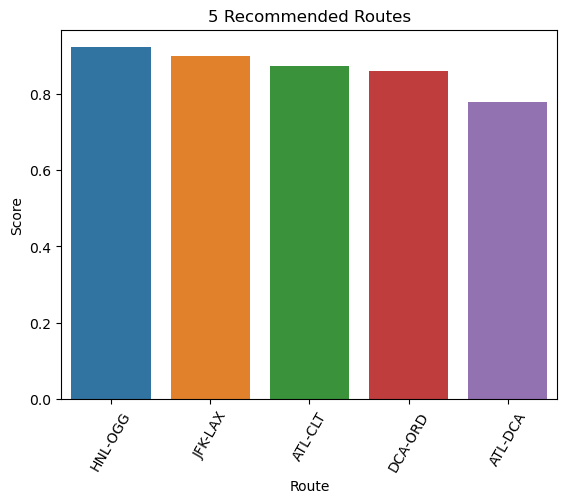

In [62]:
ax = sns.barplot(x=task_3re_top5['Route'],y=task_3re_top5['Score'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
ax.set_title("5 Recommended Routes")
plt.show()

## Task 4: the number of flights to get to breakeven
The number of round trip flights it will take to breakeven on the upfront airplane cost (each airplane will cost $90 million) for each of the 5 round trip routes that you recommend. Print key summary components for these routes.

In [64]:
task_4 = task_2.loc[[2214,577,11,132,1808],['Route','ORIGIN_CITY_NAME','Origin_TYPE','DEP_DELAY','DEST_CITY_NAME','Destination_TYPE','ARR_DELAY',\
                                             'Total_Flight_Num','Total_Passenger_Num','Total_Cost','Total_Revenue','Total_Profit']]
task_4['Total_Profit_Margin'] = task_4['Total_Profit']/task_4['Total_Revenue']
task_4['Breakeven_Flights_Num'] = (90000000/(task_4['Total_Profit']/task_4['Total_Flight_Num'])).apply(np.ceil)
task_4.rename(columns={'DEP_DELAY':'Total_Departure_Delay',
                       'ARR_DELAY':'Total_Arrival_Delay'})

,Route,ORIGIN_CITY_NAME,Origin_TYPE,Total_Departure_Delay,DEST_CITY_NAME,Destination_TYPE,Total_Arrival_Delay,Total_Flight_Num,Total_Passenger_Num,Total_Cost,Total_Revenue,Total_Profit,Total_Profit_Margin,Breakeven_Flights_Num
2214,HNL-OGG,"Honolulu, HI",large_airport,15822.00,"Kahului, HI",medium_airport,18972.00,4794,620950.00,78918192.00,184577387.50,105659195.50,0.57,4084.00
577,JFK-LAX,"New York, NY",large_airport,62522.00,"Los Angeles, CA",large_airport,67672.00,6320,821694.00,279755860.00,408381918.00,128626058.00,0.31,4423.00
11,ATL-CLT,"Atlanta, GA",large_airport,22207.00,"Charlotte, NC",large_airport,24470.00,3076,399188.00,71400240.68,210372076.00,138971835.32,0.66,1993.00
132,DCA-ORD,"Washington, DC",large_airport,48328.00,"Chicago, IL",large_airport,57969.00,3695,478814.00,102629126.20,256165490.00,153536363.80,0.60,2166.00
1808,ATL-DCA,"Atlanta, GA",large_airport,26269.00,"Washington, DC",large_airport,30060.00,3488,453738.00,91497277.48,204862707.00,113365429.52,0.55,2770.00


## Task 5: Key Performance Indicators (KPI’s)
Key Performance Indicators (KPI’s) that you recommend tracking in the future to measure the success of the round trip routes that you recommend.

here are the recommended Key Performance Indicators (KPIs) that should be tracked to measure the success of the recommended round trip routes:

1. ***Profitability Metrics:***
    * *Profit:* Tracking the actual profit generated by the round trip routes is a fundamental indicator of their success in contributing positively to the airline's bottom line.
    * *Profit Margin:* Calculating the profit margin, which is the ratio of profit to revenue, offers insights into the efficiency of cost management and pricing strategies.

2. ***Operational Performance:***
    * *Flights Number:* Monitoring the frequency of flights along the round trip routes helps gauge the route's popularity and operational efficiency.
    * *Occupancy Rate:* Measuring the occupancy rate (passenger load factor) provides an indication of how efficiently available seats are being filled.

3. ***Customer Satisfaction and Experience:***
    * *On-Time Performance:* Assessing the punctuality of flights by tracking Departure (DEP) and Arrival (ARR) delays helps maintain a positive customer experience.
    * *Customer Reviews:* Gathering passenger feedback and reviews provides insights into customer satisfaction levels and areas for improvement.

4. ***Revenue and Financial Health:***
    * *Total Revenue:* Monitoring the total revenue generated from ticket sales and other revenue sources indicates the overall financial health of the route.
    * *Yield:* Calculating the yield, which is the average fare per passenger, reflects the revenue generated per seat sold.

5. ***Demand and Market Share:***
    * *Passenger Volume:* Tracking the total number of passengers traveling the round trip routes gives a clear view of demand trends.
    * *Market Share:* Analyzing the airline's market share on these routes compared to competitors offers insights into its competitive positioning.

6. ***Operational Efficiency:***
    * *Turnaround Time:* Monitoring the time taken for aircraft to be ready for the next flight after landing influences scheduling efficiency.
    * *Utilization Rate:* Calculating the aircraft utilization rate indicates how effectively assets are being utilized.


In [65]:
# save final dataset for future analysis and visualization
final = task_3[(task_3['Total_Flight_Num']>=100) & (task_3['Total_Passenger_Num']>=10000) & (task_3['Total_Profit']>0)]
final['Total_Profit_Margin'] = final['Total_Profit']/final['Total_Revenue']
final['Breakeven_Flights_Num'] = (90000000/(final['Total_Profit']/final['Total_Flight_Num'])).apply(np.ceil)
final = final.join(task_3re['Score'])

In [66]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 0 to 2792
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Route                  2323 non-null   object 
 1   ORIGIN                 2323 non-null   object 
 2   DESTINATION            2323 non-null   object 
 3   ORIGIN_CITY_NAME       2323 non-null   object 
 4   DEST_CITY_NAME         2323 non-null   object 
 5   DEP_DELAY              2323 non-null   float64
 6   ARR_DELAY              2323 non-null   float64
 7   AIR_TIME               2323 non-null   float64
 8   Total_Flight_Num       2323 non-null   int64  
 9   DISTANCE               2323 non-null   float64
 10  Total_Passenger_Num    2323 non-null   float64
 11  ITIN_FARE              2323 non-null   float64
 12  Origin_TYPE            2323 non-null   object 
 13  Origin_NAME            2323 non-null   object 
 14  Origin_Longitude       2323 non-null   float64
 15  Orig

In [67]:
final.to_csv('final.csv', index=False)

# 5. What's Next

To ensure a comprehensive assessment of the success of the recommended round trip routes, we can do more job in:

1. ***Tickets Data Enrichment:*** Expanding the tickets data sample size to gather a more representative dataset (like distribution of Business and Economy level tickets) for the routes is crucial. Having a larger dataset will allow for a more accurate estimation of fare charges, leading to more confident decisions. Examining the distribution of Business and Economy class seats on the flights can provide insights into passenger preferences and the revenue generated from different types of tickets.

2. ***Aircraft Capacity:*** Now we assume all plane can accommodate 200 passengers, but in reality, thing could be different. It's essential to verify the passenger capacity of planes serving shorter routes, as this can significantly impact the revenue potential. Accurate information will ensure realistic revenue projections.

3. ***Baggage Revenue:*** Reviewing the revenue generated from passengers checking in baggage can help refine the estimation of ancillary revenue. Considering the likelihood of a lower percentage of passengers checking in baggage for round-trip routes is important.

4. ***Freight Transport Demand:*** Tracking the demand for freight transport can provide additional revenue streams and contribute to the overall profitability of the routes.

5. ***City Income Distribution:*** Understanding the income distribution of the city served by the route is valuable. It can indicate the potential customer base and their purchasing power, influencing fare pricing strategies.

6. ***Competition Analysis:*** Analyzing the existing airlines serving the recommended routes is crucial. Factors such as their schedules, promotional activities, and discounted ticket offerings can impact the competitiveness and success of the recommended routes.
